In [1]:
from openadmet.toolkit.chemoinformatics.data_curation import CSVProcessing
import os
import pandas as pd
import numpy as np
from typing import Optional
from collections import defaultdict
import re

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Curating compound activity data from the Tox21 Study for model training
There are a couple of PXR datasets to start with:  
1. 'AID_1347033_datatable.csv' is the summary data from https://pubchem.ncbi.nlm.nih.gov/bioassay/1347033#section=BioAssay-Type  
2. 'AID_1346982_datatable.csv' is the assay data with replicates from https://pubchem.ncbi.nlm.nih.gov/bioassay/1346982  
3. 'AID_1346977_datatable.csv' is the counter screen assay data with replicates from https://pubchem.ncbi.nlm.nih.gov/bioassay/1346977  

Use the function `process_data` to process the raw data files, i.e. add 'CANONICAL_SMILES' and 'INCHIKEY'.

In [2]:
def process_data(input_files:list, input_path:str, output_path:str, force_process:bool=False):
    '''
    Function to process csv data tables from PubChem by adding CANONICAL_SMILES and INCHIKEY with the CSVProcessing class and outputting the resulting csv file to the "processed" folder.

    You can force reprocess all csv data tables in the "input_data" folder by setting force_process=True
    OR you can process only the csv data tables that have not already been processed, aka have a corresponding csv in the "processed" folder.
    '''
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    if force_process:
        for i in input_files:
            df = CSVProcessing.read_csv(os.path.join(input_path, i))
            processor = CSVProcessing()
            data = processor.standardize_smiles_and_convert(data=df)
            data.astype(str).to_parquet(os.path.join(output_path, f"processed_{i[:-4]}.parquet"), index=False)
    
    else: # process only input files that have not already been processed
        processed_files = os.listdir(output_path)

        for i in input_files:
            if not any(i[:-3] in f[:-7] for f in processed_files):
                df = CSVProcessing.read_csv(os.path.join(input_path, i))
                processor = CSVProcessing()
                data = processor.standardize_smiles_and_convert(data=df)
                data.astype(str).to_parquet(os.path.join(output_path, f"processed_{i[:-4]}.parquet"), index=False)


## Select the protein you'd like to to process data for
1. Create a subfolder within `/input_data` with the name of your protein of interest and upload the relevant `csv` files  
2. Enter below for the `protein` variable the name of your folder as a string; after data processing, the processed files will be `/processed/{protein}`  
3. Also enter the type of activity read out for downstream data cleaning.

In [3]:
protein = "AHR"
ac50 = "EC50"

In [4]:
root = os.getcwd()
input_folder = 'input_data'
output_folder = 'processed'
input_path = os.path.join(root, input_folder, protein)
output_path = os.path.join(root, output_folder, protein)

input_files = [file for file in os.listdir(input_path) if '.csv' in file]

process_data(input_files=input_files, input_path=input_path, output_path=output_path)

## Now ingest the processed data files for cleaning
If `/processed` folder includes files from multiple proteins, will need to add some logic to get only the data files for, e.g. PXR

In [5]:
processed_files = os.listdir(output_path)
processed_files

['processed_AID_743086_datatable.parquet',
 'processed_AID_743085_datatable.parquet',
 'processed_AID_743122_datatable.parquet']

In [6]:
def make_data_dict(files, path):
    data = {}

    for i in files:
        df = pd.read_parquet(os.path.join(path, i))

        #assign human friendly names to each dataframe
        if any("Replicate" in col for col in df.columns):
            # check if 'cytotoxic' is anywhere in the dataframe
            # this will be the counter screen data
            substring="cytotoxic"
            substring_found = df.astype(str).apply(lambda x: x.str.contains(substring, case=False, na=False)).any().any()

            if substring_found:
                key = "counter"
            else:
                key = "rep"
            data[key] = df
        else:
            data["summary"] = df
    
    return data

In [7]:
data = make_data_dict(files=processed_files, path=output_path)

### Clean up the replicate data and merge
1. Get the means and standard deviations for all numeric replicate columns  
2. Calculate pAC50 from potency  
3. Drop columns that have all `NaN`  
4. Select only the newly calculated `mean` and `std` columns AND the `OPENADMET_CANONICAL_SMILES` and `INCHIKEY` columns  
5. Merge the screen replicate and counter screen replicate data

In [8]:
for key in data:

    if key == 'rep':
        # Calculate pAC50 from Potency (uM)
        # cast float to appropriate data types
        potency_cols = [col for col in data[key].columns if re.match(r"Potency-Replicate_\d+$", col)]
        for i in potency_cols:
            data[key][f"pAC50{i[7:]}"] = -np.log10(data[key][i].astype(float)*1e-6)

        # Get means and stdevs for pAC50, HillSlopes, and R2 columns
        strings = ['pAC50', 'Fit_HillSlope', 'Fit_R2']
        for i in strings:
            cols = [col for col in data[key].columns if re.match(fr"{i}-Replicate_\d+$", col)]
            data[key][f"{i.lower()}_mean"] = data[key][cols].astype(float).mean(axis=1)
            data[key][f"{i.lower()}_std"] = data[key][cols].astype(float).std(axis=1)

    
    elif key == 'counter':
        # Get counter screen viable data from first 3 phenotype-replicate columns
        data[key]['counter_phenotype'] = data[key][['Phenotype-Replicate_1', 'Phenotype-Replicate_2', 'Phenotype-Replicate_3']].mode(axis=1)[0]

    print(len(data[key]))
        

10287
10287
10287


In [9]:
# Merge and average biological replicates

rep_cols = [col for col in data['rep'].columns if "_mean" in col or "_std" in col]
select_cols = ["INCHIKEY"] + rep_cols
rep_df = data['rep'][select_cols].groupby("INCHIKEY", as_index=False).agg(
    {**{col: 'mean' for col in rep_cols}}
    )

counter_df = (data['counter'][["INCHIKEY", "counter_phenotype"]].groupby("INCHIKEY", as_index=False)
    .agg({"counter_phenotype": lambda x: x.mode().iloc[0]})
    )

sum_cols = ["OPENADMET_CANONICAL_SMILES", "PUBCHEM_ACTIVITY_OUTCOME"]

summary_df = (
    data['summary'][["INCHIKEY"] + sum_cols]
    .groupby("INCHIKEY", as_index=False)
    .agg({col: lambda x: x.mode().iloc[0] for col in sum_cols})
)

In [10]:
merged = summary_df.merge(rep_df, on="INCHIKEY", how="inner")
merged = merged.merge(counter_df, on="INCHIKEY", how="inner")
merged

,INCHIKEY,OPENADMET_CANONICAL_SMILES,PUBCHEM_ACTIVITY_OUTCOME,pac50_mean,pac50_std,fit_hillslope_mean,fit_hillslope_std,fit_r2_mean,fit_r2_std,counter_phenotype
0,AADCDMQTJNYOSS-LBPRGKRZSA-N,CCC1=CC(Cl)=C(OC)C(C(=O)NC[C@@H]2CCCN2CC)=C1O,Inactive,4.750066,NaN,2.997517,2.092260,0.734500,0.221628,Inactive
1,AADVZSXPNRLYLV-GKMXPDSGSA-N,O=C(O)[C@@H]1[C@H]2C[C@H]3C4=C(CCN3C[C@@H]2CC[...,Inconclusive,5.094668,0.070711,1.824567,0.664793,0.836233,0.166103,Inactive
2,AAEVYOVXGOFMJO-UHFFFAOYSA-N,CSC1=NC(NC(C)C)=NC(NC(C)C)=N1,Inactive,4.464848,NaN,3.845400,0.465983,0.627200,0.186676,Inactive
3,AAFXQFIGKBLKMC-KQQUZDAGSA-N,O=C(O)/C=C/C1=CC=C(/C=C/C(=O)O)C=C1,Inactive,NaN,NaN,4.524950,0.608041,0.622700,0.203647,Inactive
4,AAIBYZBZXNWTPP-UHFFFAOYSA-N,OC1CCCCC1C1=CC=CC=C1,Inactive,NaN,NaN,2.927450,2.867247,0.557100,0.017395,Inactive
...,...,...,...,...,...,...,...,...,...,...
7561,ZZVUWRFHKOJYTH-UHFFFAOYSA-N,CN(C)CCOC(C1=CC=CC=C1)C1=CC=CC=C1,Inactive,4.260659,NaN,3.703137,0.600687,0.606375,0.101918,Inactive
7562,ZZXDRXVIRVJQBT-UHFFFAOYSA-N,CC1=CC=CC(S(=O)(=O)O)=C1C,Inactive,NaN,NaN,2.406400,NaN,0.424200,NaN,Inactive
7563,ZZXUZKXVROWEIF-UHFFFAOYSA-N,CCC1COC(=O)O1,Inactive,NaN,NaN,0.200000,NaN,0.314500,NaN,Inactive
7564,ZZYSLNWGKKDOML-UHFFFAOYSA-N,CCC1=NN(C)C(C(=O)NCC2=CC=C(C(C)(C)C)C=C2)=C1Cl,Inactive,NaN,NaN,2.406400,NaN,0.447300,NaN,Inactive


### Input final columns and rename

In [11]:
merged.rename(columns={"pac50_mean": "OPENADMET_LOGAC50", "pac50_std": "OPENADMET_LOGAC50_STD"}, inplace=True)
merged["OPENADMET_ACTIVITY_OUTCOME"] = merged["PUBCHEM_ACTIVITY_OUTCOME"].str.lower()
merged["OPENADMET_ACTIVITY_COMMENT"] = ac50
merged["OPENADMET_COUNTERSCREEN_VIABLE"] = np.where(
    merged['counter_phenotype'].str.lower() == "cytotoxic", False, True
)

final_cols = [
    "INCHIKEY",
    "OPENADMET_CANONICAL_SMILES",
    "OPENADMET_LOGAC50",
    "OPENADMET_LOGAC50_STD",
    "OPENADMET_ACTIVITY_COMMENT",
    "OPENADMET_ACTIVITY_OUTCOME",
    "OPENADMET_COUNTERSCREEN_VIABLE",
    "fit_hillslope_mean",
    "fit_hillslope_std",
    "fit_r2_mean",
    "fit_r2_std"
]
full_df = merged[final_cols]
full_df

,INCHIKEY,OPENADMET_CANONICAL_SMILES,OPENADMET_LOGAC50,OPENADMET_LOGAC50_STD,OPENADMET_ACTIVITY_COMMENT,OPENADMET_ACTIVITY_OUTCOME,OPENADMET_COUNTERSCREEN_VIABLE,fit_hillslope_mean,fit_hillslope_std,fit_r2_mean,fit_r2_std
0,AADCDMQTJNYOSS-LBPRGKRZSA-N,CCC1=CC(Cl)=C(OC)C(C(=O)NC[C@@H]2CCCN2CC)=C1O,4.750066,NaN,EC50,inactive,True,2.997517,2.092260,0.734500,0.221628
1,AADVZSXPNRLYLV-GKMXPDSGSA-N,O=C(O)[C@@H]1[C@H]2C[C@H]3C4=C(CCN3C[C@@H]2CC[...,5.094668,0.070711,EC50,inconclusive,True,1.824567,0.664793,0.836233,0.166103
2,AAEVYOVXGOFMJO-UHFFFAOYSA-N,CSC1=NC(NC(C)C)=NC(NC(C)C)=N1,4.464848,NaN,EC50,inactive,True,3.845400,0.465983,0.627200,0.186676
3,AAFXQFIGKBLKMC-KQQUZDAGSA-N,O=C(O)/C=C/C1=CC=C(/C=C/C(=O)O)C=C1,NaN,NaN,EC50,inactive,True,4.524950,0.608041,0.622700,0.203647
4,AAIBYZBZXNWTPP-UHFFFAOYSA-N,OC1CCCCC1C1=CC=CC=C1,NaN,NaN,EC50,inactive,True,2.927450,2.867247,0.557100,0.017395
...,...,...,...,...,...,...,...,...,...,...,...
7561,ZZVUWRFHKOJYTH-UHFFFAOYSA-N,CN(C)CCOC(C1=CC=CC=C1)C1=CC=CC=C1,4.260659,NaN,EC50,inactive,True,3.703137,0.600687,0.606375,0.101918
7562,ZZXDRXVIRVJQBT-UHFFFAOYSA-N,CC1=CC=CC(S(=O)(=O)O)=C1C,NaN,NaN,EC50,inactive,True,2.406400,NaN,0.424200,NaN
7563,ZZXUZKXVROWEIF-UHFFFAOYSA-N,CCC1COC(=O)O1,NaN,NaN,EC50,inactive,True,0.200000,NaN,0.314500,NaN
7564,ZZYSLNWGKKDOML-UHFFFAOYSA-N,CCC1=NN(C)C(C(=O)NCC2=CC=C(C(C)(C)C)C=C2)=C1Cl,NaN,NaN,EC50,inactive,True,2.406400,NaN,0.447300,NaN


In [12]:
full_df["OPENADMET_LOGAC50"].isna().sum()

4546

In [13]:
full_df = full_df.loc[~full_df["OPENADMET_LOGAC50"].isna()]

In [14]:
final_output = 'final'
final_output_path = os.path.join(root, final_output)

full_df.to_parquet(os.path.join(final_output_path, f"cleaned_{protein}_tox21_data.parquet"), index=False)

# Exploratory Data Analysis

In [15]:
full_df.loc[full_df['OPENADMET_ACTIVITY_OUTCOME'] == 'active']

,INCHIKEY,OPENADMET_CANONICAL_SMILES,OPENADMET_LOGAC50,OPENADMET_LOGAC50_STD,OPENADMET_ACTIVITY_COMMENT,OPENADMET_ACTIVITY_OUTCOME,OPENADMET_COUNTERSCREEN_VIABLE,fit_hillslope_mean,fit_hillslope_std,fit_r2_mean,fit_r2_std
5,AAKJLRGGTJKAMG-UHFFFAOYSA-N,C#CC1=CC=CC(NC2=NC=NC3=CC(OCCOC)=C(OCCOC)C=C23...,5.725028,0.983553,EC50,active,False,0.600000,0.100000,0.928633,0.015959
29,ADAKRBAJFHTIEW-UHFFFAOYSA-N,O=C=NC1=CC=C(Cl)C=C1,5.297074,1.187785,EC50,active,True,2.284967,2.312771,0.905633,0.044800
35,ADVGKWPZRIDURE-UHFFFAOYSA-N,CC(=O)NC1=CC=CC=C1O,4.297075,0.104083,EC50,active,True,1.940267,0.411789,0.943733,0.018553
58,AFPRJLBZLPBTPZ-UHFFFAOYSA-N,O=C1C(=O)C2=CC=CC3=CC=CC1=C23,4.597516,0.028868,EC50,active,True,3.569933,2.398833,0.884000,0.131054
60,AFYCEAFSNDLKSX-UHFFFAOYSA-N,CCN(CC)C1=CC=C2C(C)=CC(=O)OC2=C1,4.603648,0.375279,EC50,active,True,2.154780,0.751601,0.873993,0.045454
...,...,...,...,...,...,...,...,...,...,...,...
7520,ZWUBBMDHSZDNTA-UHFFFAOYSA-N,NC1=CC=C(Cl)C(N)=C1,4.788080,0.241772,EC50,active,True,0.924050,0.250332,0.952283,0.036582
7527,ZXFQRFXLFWWKLX-UHFFFAOYSA-N,COC1=CC=C2C(=O)C(C)=C(C3=CC=CC=C3)OC2=C1CN(C)C,4.658399,0.230941,EC50,active,True,2.604800,1.364597,0.907633,0.073004
7535,ZXUMUPVQYAFTLF-UHFFFAOYSA-N,CCC(N)CC1=CNC2=CC=CC=C12,4.312505,0.200000,EC50,active,True,3.280233,0.589178,0.772700,0.101931
7548,ZZEYCGJAYIHIAZ-UHFFFAOYSA-N,CC1CN(C2=CC=CC=C2)NC1=O,4.547075,0.115470,EC50,active,True,3.064367,1.653887,0.959100,0.037214


<Axes: xlabel='OPENADMET_ACTIVITY_OUTCOME', ylabel='Count'>

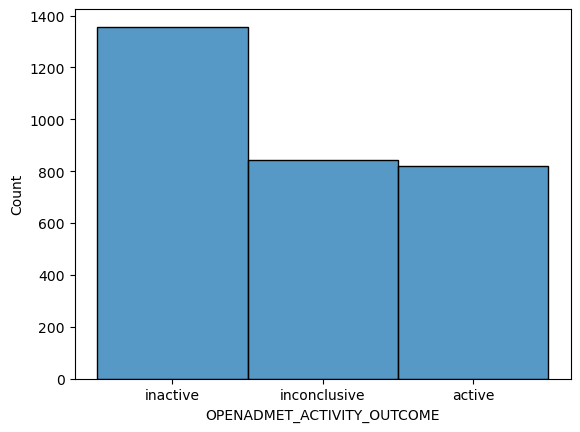

In [16]:
sns.histplot(data=full_df, x='OPENADMET_ACTIVITY_OUTCOME')

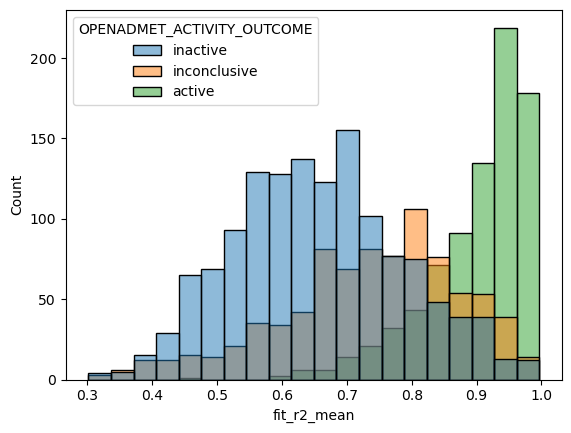

In [17]:
cols = [x for x in full_df.columns if 'r2_mean' in x]
for i in cols:
    sns.histplot(data=full_df, x=i, hue='OPENADMET_ACTIVITY_OUTCOME')
    plt.show()

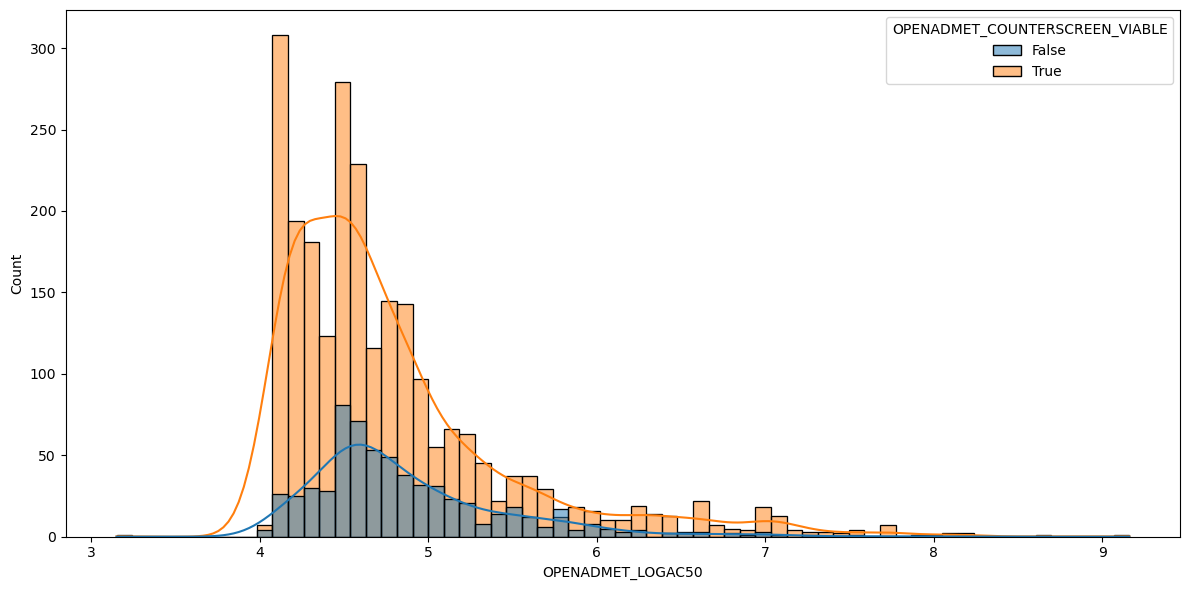

In [18]:
plt.figure(figsize=(12, 6))  # width=12 inches, height=6 inches
sns.histplot(data=full_df, x= 'OPENADMET_LOGAC50', hue='OPENADMET_COUNTERSCREEN_VIABLE', kde=True)
# plt.yscale('log')
plt.tight_layout()
plt.show()

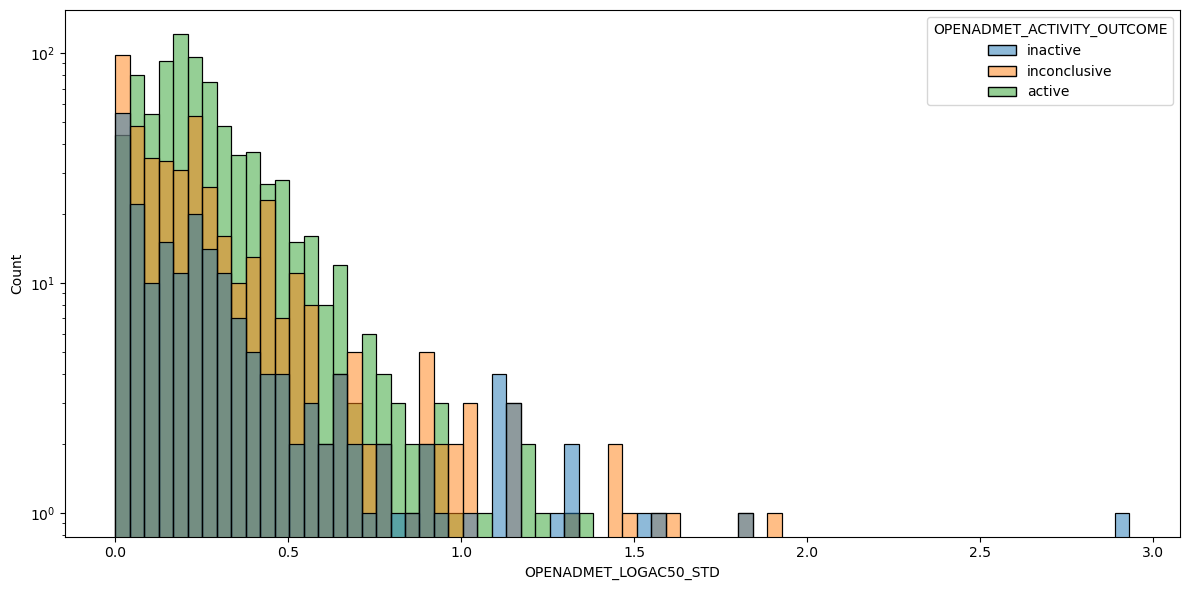

In [19]:
plt.figure(figsize=(12, 6))  # width=12 inches, height=6 inches
sns.histplot(data=full_df, x= 'OPENADMET_LOGAC50_STD', hue='OPENADMET_ACTIVITY_OUTCOME')
plt.yscale('log')
plt.tight_layout()
plt.show()

## Depreciated code that I can't emotionally let go of

In [20]:
# def clean_rep_data(df, type:Optional[str]=None):
#     rep_cols = [x for x in df.columns if 'Replicate' in x and np.issubdtype(df[x].dtype, np.number) and 'Activity at' not in x]
#     # Remove the activity at X uM columns; these are used data points for fitting the Hill Eqn (i assume)
#     grouped_cols = defaultdict(list)

#     for col in rep_cols:
#         base_name = re.sub(r"-?Replicate_\d+$", "", col)
#         grouped_cols[base_name].append(col)

#     for base, cols in grouped_cols.items():
#         if type:
#             mean_col = f"{type}_{base.lower()}_mean"
#             std_col = f"{type}_{base.lower()}_std"
#         else:
#             mean_col = f"{base.lower()}_mean"
#             std_col = f"{base.lower()}_std"
#         df[mean_col] = df[cols].mean(axis=1)
#         df[std_col] = df[cols].std(axis=1)

#         # Compute pAC50 only if this is a potency column
#         if "potency" in base.lower():
#             pac50_mean_col = f"{type}_pAC50_mean" if type else "pAC50_mean"
#             pac50_std_col = f"{type}_pAC50_std" if type else "pAC50_std"
            
#             df[pac50_mean_col] = -np.log10(df[mean_col] * 10**-6)
#             df[pac50_std_col] = -np.log10(df[std_col] * 10**-6)
            
#         # Drop mean column if all values are NaN
#         if df[mean_col].isna().all():
#             df.drop(columns=[mean_col], inplace=True)
        
#         # Drop std column if all values are NaN
#         if df[std_col].isna().all():
#             df.drop(columns=[std_col], inplace=True)
    
#     new_cols = [x for x in df.columns if "_mean" in x or "_std" in x]
#     select_cols = ["OPENADMET_CANONICAL_SMILES", "INCHIKEY"]+ new_cols

#     clean_df = df[select_cols]
#     # Average biological replicates by INCHIKEY
#     clean_df = (
#         df[select_cols]
#         .groupby("INCHIKEY", as_index=False)
#         .agg({**{col: 'first' for col in ["OPENADMET_CANONICAL_SMILES"]},
#             **{col: 'mean' for col in new_cols}})
#     )

#     return clean_df

In [21]:
## this is the revisions
# from pydantic import BaseModel, Field
# from typing import Optional
# from rdkit import Chem

# from openadmet.toolkit.chemoinformatics.rdkit_funcs import canonical_smiles, smiles_to_inchikey

# class CSVProcessing(BaseModel):
#     """
#     Class to handle processing data from a csv downloaded

#     """
#     smiles_col: Optional[str] = None

#     @staticmethod
#     def read_csv(csv_path, sep=","):
#         """
#         Wrapper for inbuilt pandas read_csv()
#         """
#         return pd.read_csv(csv_path, sep=sep)

#     def standardize_smiles_and_convert(self, data):
#         """
#         Converts data to canonical smiles and determines inchikey

#         Parameters
#         ----------
#         data : DataFrame
#             Dataframe of csv of downloaded compound data

#         Returns
#         -------
#         data : DataFrame
#             Dataframe with smiles canonicalized and inchikey
#             column added
#         """

#         if self.smiles_col:
#             if self.smiles_col not in data.columns:
#                 raise ValueError("The provided column is not in the data table!")
#             else:
#                 data["CANONICAL_SMILES"] = data[self.smiles_col].apply(lambda x: canonical_smiles(x))
#                 data["INCHIKEY"] = data["CANONICAL_SMILES"].apply(
#                     lambda x: smiles_to_inchikey(x)
#                 )
#         else:
#             # Get column with SMILES string
#             cols = [col for col in data.columns if 'smiles' in col.lower()]

#             if len(cols) == 1:
#                 col = cols[0]
#                 data["CANONICAL_SMILES"] = data[col].apply(lambda x: canonical_smiles(x))
#                 data["INCHIKEY"] = data["CANONICAL_SMILES"].apply(
#                     lambda x: smiles_to_inchikey(x)
#                 )
                
#             else:
#                 raise ValueError("Multiple columns with SMILES strings detected! Choose one for CANONICAL_SMILES.")

#         data.dropna(subset="INCHIKEY", inplace=True)
#         return data